# Mutation rate analysis

## Background

We want to distinguish between two mutational models for GCs:
1. The mutation process is continuous during DZ proliferation.
2. The mutation process is punctuated, acting only at the last cell division.

This question is closely analogous to the classical [Luria–Delbrück](https://en.wikipedia.org/wiki/Luria–Delbrück_experiment) calculation (1969 Nobel prize).

### Model 2: Last-cycle mutation

Let $n_i$ denote the number of cells in the $i$–th burst (out of $N$), let $p$ denote the probability of a last-cycle mutation, and let r.v. $m_i$ denote the number of mutated cells in the $i$–th burst.
Then
$$
m_i \sim \text{Binomial}(n_i, p), \quad i = 1, 2, \ldots, N.
$$

### Model 1: Continuous mutation process

If mutations can be inherited, the distribution of $m_i$ is more complicated and overdispersed.
Following Luria and Delbrück, we will use a two-type Yule process to model the distribution of $m_i$.
Fix birth rate $\lambda=1$ and mutation rate $\mu = 2p$ from type 1 to type 2, and run until population size $n_i$.
Then
$$
m_i \sim \dots
$$


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter
import bdms

In [3]:
df = pd.read_excel("240402Burst_summary_wDZdensity.xlsx", index_col=0).iloc[:, :12]

df = df.loc[df["# total GC seq"] >= df["# in bursting node"] + df["# desc of bursting node"]]
df = df.loc[df["Fig 1. ID"].isna() == False, :]
df = df.astype({"Fig 1. ID": int, "# total GC seq": int, "# in bursting node": int, "# desc of bursting node": int})

df["# total in burst"] = df["# in bursting node"] + df["# desc of bursting node"]
df["population fraction estimate"] = df["BB(DZ) density"] * df["# total in burst"] / df["# total GC seq"]
df["parental fraction"] = df["# in bursting node"] / df["# total in burst"]

df.to_csv("output/data.csv")

df

,Fig 1. ID,# in bursting node,# desc of bursting node,# total GC seq,BB density,BB(DZ) density,NDS,Normalization factor,Norm burst,Norm desc,Unnamed: 11,# divisions,# total in burst,population fraction estimate,parental fraction
ID,,,,,,,,,,,,,,,
C_GC3_2,1,31,42,78,0.748,1.006586,NaN,25.809893,800.106672,1084.015491,42.465753,9.644049,73,0.942061,0.424658
C_GC5_3,2,15,15,44,0.656,0.907424,NaN,41.246534,618.698012,618.698012,50.000000,9.273092,30,0.618698,0.500000
M8-5.2:3_1 RY,4,13,55,89,0.610,0.920926,NaN,20.694972,269.034632,1138.223444,19.117647,8.071648,68,0.703629,0.191176
M8-4.1:2_1 Y,3,17,49,90,0.661,0.797423,NaN,17.720517,301.248796,868.305352,25.757576,8.234812,66,0.584777,0.257576
M9-6.1:4_1 R,5,13,40,82,0.473,0.950910,NaN,23.192924,301.508013,927.716963,24.528302,8.236053,53,0.614612,0.245283


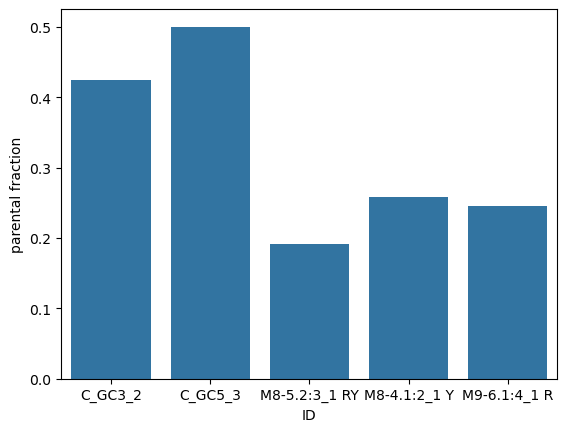

In [4]:
sns.barplot(data=df, x=df.index, y="parental fraction")
plt.show()

## Simulation

In [5]:
birth_rate = 1.0
stop_death_rate = 100. * birth_rate
stop_freq = .048

types = [0, 1, 2]

P = np.array([
    [0, 1 - stop_freq, stop_freq],
    [0, 1 - stop_freq, stop_freq],
    [0, 0, 1]
])

birth_process = bdms.poisson.ConstantProcess(birth_rate)
death_process = bdms.poisson.DiscreteProcess([0, 0, stop_death_rate])
mutation_process = bdms.poisson.ConstantProcess(0.0)
mutator = bdms.mutators.DiscreteMutator(types, P)

n_attempts = 20

viz_kwargs = dict(
    color_map={0: "lightgrey", 1: "black", 2: "red"},
    units="in",
    h=2,
    mode="c",
    scale=10,
)

In [6]:
def null_sim(mutation_prob, N, n, rng, render=False):
    tree = bdms.Tree(state=0)
    for attempt in range(n_attempts):
        try:
            tree.evolve(
                np.inf,
                birth_process=birth_process,
                death_process=death_process,
                mutation_process=mutation_process,
                mutator=mutator,
                birth_mutation_prob=mutation_prob,
                capacity=N,
                capacity_method="stop",
                min_survivors=n,
                seed=rng,
            )
            break
        except bdms.tree.TreeError as e:
            if attempt == n_attempts - 1:
                raise e
            else:
                print(f"TreeError, retry {attempt + 1}\n", flush=True)
                continue

    tree.sample_survivors(n=n, seed=rng)
    tree.prune_unsampled()

    if render:
        display(tree.render("%%inline", **viz_kwargs))

    type_counts = Counter(leaf.state for leaf in tree)
    type_counts_total = type_counts.total()

    return type_counts[0], type_counts[1] + type_counts[2], type_counts_total, type_counts[0] / type_counts_total
    

In [12]:
N_total = 2000
n_sim = 1000
rng = np.random.default_rng(seed=0)

mutation_probs = np.geomspace(0.01, 0.99, 10)

dat = []
for mutation_prob in mutation_probs:
    print(f"{mutation_prob=:.2f}", flush=True)
    for gc in df.index:
        print(f"  {gc}")
        N = round(N_total * df.loc[gc, "population fraction estimate"])
        n = df.loc[gc, "# total in burst"]
        for i in range(n_sim):
            print(f"    {i=}", end="    \r", flush=True)
            dat.append([mutation_prob, gc, i, *null_sim(mutation_prob, N, n, rng)])

        # p = (sim_df["parental fraction"] >= n_parental_true / n).mean()
        # if p == 0:
        #     p = 1 / n_sim
        #     p_rel = "<"
        # else:
        #     p_rel = "="

        # print(f"  n_parental_sim_mean={sim_df['parental fraction'].mean():.2f}, p{p_rel}{p:.1e}", flush=True)

sim_df = pd.DataFrame(dat,
                    columns=["mutation_prob", "GC", "sim", "n_parental", "n_mutated", "n_burst", "parental_fraction"])
sim_df.to_csv(f"output/sim.csv")

mutation_prob=0.01
  C_GC3_2


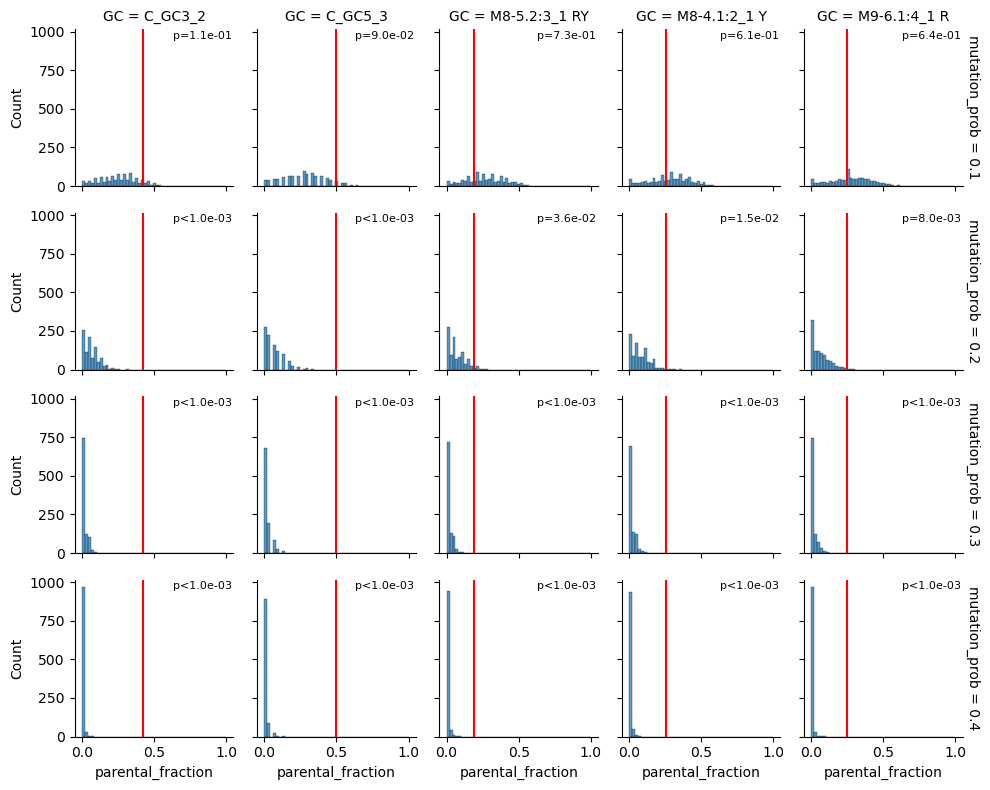

In [ ]:
g = sns.displot(data=sim_df, x="parental_fraction", row="mutation_prob", col="GC", kind="hist", bins=np.linspace(0, 1, 50),
            height=2, aspect=1, facet_kws=dict(margin_titles=True))

for mutation_prob in mutation_probs:
    for gc in df.index:
        plt.sca(g.axes_dict[(mutation_prob, gc)])
        n = df.loc[gc, "# total in burst"]
        n_parental_true = df.loc[gc, "# in bursting node"]
        plt.axvline(n_parental_true / n, color="red")
        n_parental_sims = sim_df.query(f"GC == '{gc}' and mutation_prob == {mutation_prob}").n_parental
        p = (n_parental_sims >= n_parental_true).mean()
        if p == 0:
            p = 1 / n_sim
            p_rel = "<"
        else:
            p_rel = "="
        plt.annotate(f"p{p_rel}{p:.1e}",
                    (0.99, 0.99), xycoords="axes fraction", ha="right", va="top",
                    fontsize=8)

plt.tight_layout()
plt.savefig(f"output/sim.pdf")
plt.show()